In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import talib
import pickle
import pystan

import os, sys

sys.path.append(os.path.abspath(os.path.join('')))
from generative_models import *
from fast_dm_simulator import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

## Network architecture

In [5]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        # predict static
        preds_stat = self.static_predictor(rep)

        return preds_dyn, preds_stat

class StaticHeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        
    def call(self, x):
        """
        Forward pass through the model.
        """
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        return preds_dyn

## Load trained network

In [69]:
# initialize network
network = HeteroscedasticNetwork(6, 6)
network.load_weights('model_comp/checkpoints/varying_hyperparams_3200')

## Data simulation

In [92]:
# n_sim simulated datasets
n_obs = 3200
n_sim = 10
prior_draws = dynamic_prior(n_sim)
context = context_gen(n_sim, n_obs)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)

# prepare simulated data for amortized inference
context = to_categorical(sim_data[:, :, 1])
rt = sim_data[:, :, 0, np.newaxis]
x_nn = tf.concat((rt, context), axis=-1)
x_nn.shape

TensorShape([10, 3200, 5])

# Evaluation

## Dynamic parameter recovery

In [111]:
def plot_dynamic_posteriors(dynamic_posterior, par_labels, par_names, 
                            ground_truths=None, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
    
    assert len(dynamic_posterior.shape) == 3, "Dynamic posterior should be 3-dimensional!" 
    assert ground_truths is None or len(ground_truths.shape) == 2,'Ground truths should be 2-dimensional!'
    assert dynamic_posterior.shape[0] == 1, "Function assumes dynamics posterior for a single data set!" 
        
    means = dynamic_posterior.mean()[0]
    std = dynamic_posterior.stddev()[0]
    
    post_max = np.array(means).max(axis=0).max()
    upper_y_ax = post_max + 1

    sigma_factors = [1]
    alphas = [0.6]
    serif_font = "Computer Modern Roman"
    serif_font = "Palatino"

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    counter = 0
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, alpha=0.8, label='Posterior mean', lw=1)
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Posterior sd')
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='solid', alpha=0.8, label='True Dynamic', lw=1)
        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)', fontsize=18)
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)
        if i < 4:
            ax.set_ylim(0, upper_y_ax)
        else:
            ax.set_ylim(0)
        ax.grid(False)

        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

    f.tight_layout()
    f.savefig("simulated_param_dynamic.png", dpi=300, bbox_inches="tight")

In [97]:
%%time
which = 2
# amortized inference
post_d, post_s = network(x_nn[which:(which+1)])

CPU times: user 4.93 s, sys: 42.7 ms, total: 4.97 s
Wall time: 4.96 s


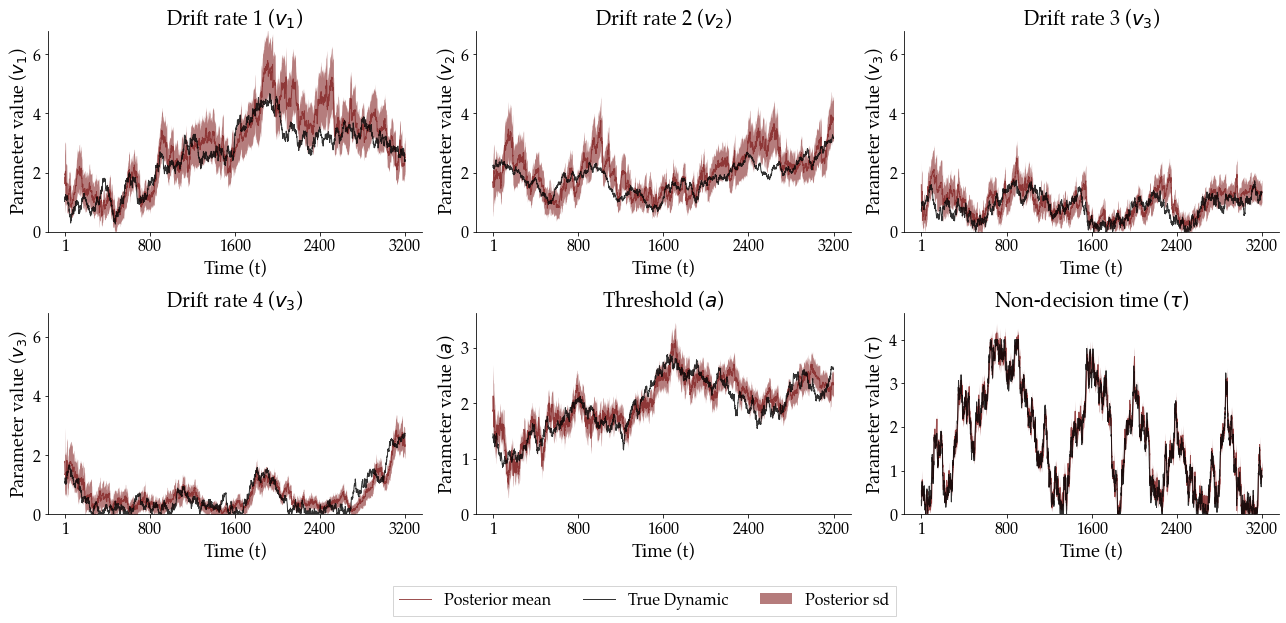

In [112]:
# get data generating parameters
ground_truths = theta_d[which]
par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_3$', r'$a$', r'$\tau$']
# plot parameter recovery
plot_dynamic_posteriors(post_d, par_labels, par_names, ground_truths)

## Predicted vs. simulated data

In [99]:
def pr_check(true_data, post_d, n_sim, sma_period=5):
    # get experimental context
    context = np.int32(true_data[:, 1])
    # get empirical response times
    emp_rt = np.abs(true_data[:, 0])
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    theta_d = np.array([post_d.sample(n_sim)])[0, :, 0, :]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta_d[sim, t, context[t]], theta_d[sim, t, 4], theta_d[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt

In [100]:
def reorderLegend2(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

In [101]:
%%time
pred_rt_dynamic, sma_pred_rt_dynamic = pr_check(sim_data[which], post_d, 1000)

CPU times: user 5min 19s, sys: 2.33 s, total: 5min 21s
Wall time: 5min 21s


In [102]:
# summarize predicted response times
quantiles = np.quantile(sma_pred_rt_dynamic, [0.05, 0.95], axis=0)
median = np.median(sma_pred_rt_dynamic, axis=0)

In [103]:
# prepare emp rt data
emp_rt = np.abs(sim_data[which, :, 0])
n_obs = emp_rt.shape[0]
sma_emp_rt = talib.SMA(emp_rt, timeperiod=5)

In [104]:
# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

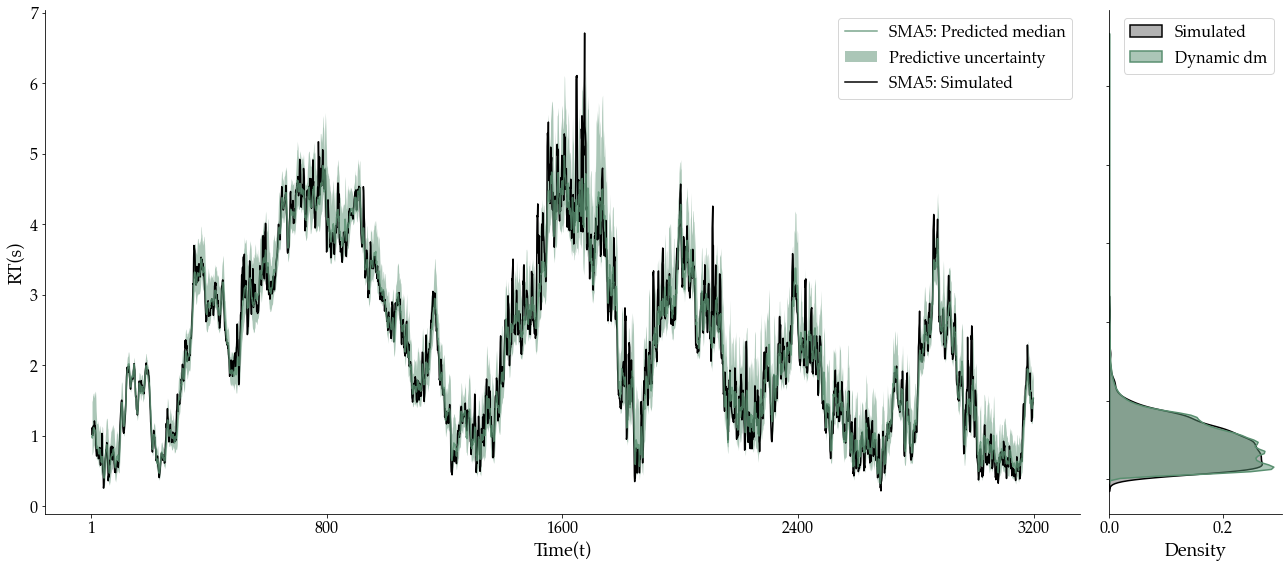

In [113]:
# initialize figure
f, ax = plt.subplots(1, 2, figsize=(18, 8),
                     gridspec_kw={'width_ratios': [6, 1]})

axrr = ax.flat

# plot empiric and predicted response times series
time = np.arange(n_obs) 
axrr[0].plot(time, sma_emp_rt, color='black', lw=1.5, label='SMA5: Simulated')
axrr[0].plot(time, median, color='#598f70', lw=1.5, label='SMA5: Predicted median', alpha=0.8)
axrr[0].fill_between(time, quantiles[0, :], quantiles[1, :], color='#598f70', linewidth=0, alpha=0.5, label='Predictive uncertainty')

sns.despine(ax=axrr[0])
axrr[0].grid(alpha=0.3)
axrr[0].set_ylabel('RT(s)', fontsize=18)
axrr[0].set_xlabel('Time(t)', fontsize=18)
axrr[0].tick_params(axis='both', which='major', labelsize=16)
axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

reorderLegend2(axrr[0],['SMA5: Empiric', 'SMA5: Predicted median', 'Predictive uncertainty'])
axrr[0].grid(b=None)

# plt.setp(ax, ylim=(0, 1.5))
sns.kdeplot(y=np.abs(emp_rt), fill="black", color="black", linewidth=1.5, alpha=0.3, label="Simulated", ax=axrr[1])
sns.kdeplot(y=pred_rt_dynamic.flatten(),fill="#598f70", color="#598f70", linewidth=1.5, alpha=0.5, label="Dynamic dm", ax=axrr[1])

axrr[1].legend(fontsize=16)
axrr[1].set_xlabel('Density', fontsize=18)
axrr[1].tick_params(axis='both', which='major', labelsize=16)
axrr[1].set_yticklabels('')
sns.despine(ax=axrr[1])
plt.subplots_adjust(wspace = 0.05)
f.tight_layout()
f.savefig("simulated_rt_time_series.png", dpi=300)